# Etapa 8: Gráficos de Módulo e Fase (Pós-processamento e Filtragem)


**Objetivo:** Visualizar como o espectro foi afetado pelo processamento e filtragem.


**Tarefas:**
* Comparar os gráficos gerados nesta etapa com os da Etapa 4.
* Observar se componentes importantes foram perdidos ou atenuados.
* Recalcular o espectro do sinal modificado.
* Criar novos gráficos de módulo e fase.
* Comparar com os gráficos originais.

**Entrega esperada:**
* Gráficos atualizados de módulo e fase.
* Comparação lado a lado com os gráficos anteriores.
* Texto explicando os efeitos da filtragem/processamento sobre o conteúdo espectral.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from scipy.signal import butter, filtfilt


## Recuperação dos Sinais das Etapas Anteriores


In [9]:
# Reproduzir todo o processamento das etapas anteriores
# Parâmetros do sinal (consistente com todas as etapas)
f_fundamental = 1  # Hz
T = 1 / f_fundamental # Período
amplitude = 1
n_ciclos_plot = 3 # Número de ciclos para plotagem

# Parâmetros de digitalização
fs_escolhida = 20 # Hz - Frequência de amostragem
N_bits = 4 # Número de bits para quantização
L = 2**N_bits  # Número de níveis de quantização

# 1. Gerar sinal digital original (Etapa 5)
t_amostrado = np.arange(0, n_ciclos_plot * T, 1/fs_escolhida)
sinal_amostrado = amplitude * signal.square(2 * np.pi * f_fundamental * t_amostrado)

# Quantização
sinal_normalizado = (sinal_amostrado + amplitude) / (2 * amplitude)
niveis_quantizados_indices = np.round(sinal_normalizado * (L - 1))
sinal_quantizado_normalizado = niveis_quantizados_indices / (L - 1)
sinal_digital_original = (sinal_quantizado_normalizado * (2 * amplitude)) - amplitude

# 2. Aplicar processamento (Etapa 6)
def adicionar_ruido_awgn(sinal, snr_db):
    potencia_sinal = np.mean(sinal**2)
    snr_linear = 10**(snr_db/10)
    potencia_ruido = potencia_sinal / snr_linear
    sigma_ruido = np.sqrt(potencia_ruido)
    ruido = np.random.normal(0, sigma_ruido, len(sinal))
    return sinal + ruido, ruido

np.random.seed(42)  # Para reprodutibilidade
sinal_com_ruido, _ = adicionar_ruido_awgn(sinal_digital_original, 8)  # SNR = 8 dB
sinal_processado = np.clip(sinal_com_ruido, -0.7, 0.7)  # Clipping em ±0.7

# 3. Aplicar filtragem (Etapa 7)
def projetar_filtro_pb(freq_corte, fs, ordem=4):
    nyquist = fs / 2
    freq_norm = freq_corte / nyquist
    b, a = butter(ordem, freq_norm, btype='lowpass')
    return b, a

freq_corte_pb = 3  # Hz
b_pb, a_pb = projetar_filtro_pb(freq_corte_pb, fs_escolhida, 4)
sinal_filtrado_final = filtfilt(b_pb, a_pb, sinal_processado)

# Sinal contínuo de referência
t_continuo = np.linspace(0, n_ciclos_plot * T, 1000, endpoint=False)
onda_quadrada_continua = amplitude * signal.square(2 * np.pi * f_fundamental * t_continuo)

print("Sinais recuperados:")
print(f"- Sinal digital original: {len(sinal_digital_original)} amostras")
print(f"- Sinal processado (ruído + clipping): RMS = {np.sqrt(np.mean(sinal_processado**2)):.4f}")
print(f"- Sinal filtrado final: RMS = {np.sqrt(np.mean(sinal_filtrado_final**2)):.4f}")


Sinais recuperados:
- Sinal digital original: 60 amostras
- Sinal processado (ruído + clipping): RMS = 0.6754
- Sinal filtrado final: RMS = 0.6254


## Recálculo dos Espectros (Módulo e Fase)


In [10]:
def calcular_espectro_completo(sinal, fs, titulo="Espectro"):
    """Calcula módulo e fase do espectro de um sinal"""
    N = len(sinal)
    Y = fft.fft(sinal)
    freqs = fft.fftfreq(N, d=1/fs)
    
    # Pegar apenas a parte positiva
    N_metade = N // 2
    Y_metade = Y[:N_metade]
    freqs_metade = freqs[:N_metade]
    
    # Calcular módulo
    modulo = np.abs(Y_metade) * (2 / N)
    modulo[0] = np.abs(Y_metade[0]) / N  # Correção para DC
    
    # Calcular fase
    fase = np.angle(Y_metade)
    
    # Limpar a fase para componentes com módulo muito pequeno
    threshold_modulo = 1e-3 * np.max(modulo)
    fase[modulo < threshold_modulo] = 0
    
    return freqs_metade, modulo, fase

# Calcular espectros de todos os sinais importantes
print("Calculando espectros...")

# 1. Sinal digital original (referência da Etapa 4)
freqs_original, modulo_original, fase_original = calcular_espectro_completo(sinal_digital_original, fs_escolhida)

# 2. Sinal após processamento (Etapa 6)
freqs_processado, modulo_processado, fase_processado = calcular_espectro_completo(sinal_processado, fs_escolhida)

# 3. Sinal após filtragem (Etapa 7)
freqs_filtrado, modulo_filtrado, fase_filtrado = calcular_espectro_completo(sinal_filtrado_final, fs_escolhida)

# 4. Para comparação, vamos também calcular o espectro do sinal contínuo ideal
# Usando mais pontos para melhor resolução espectral
N_pontos_fft = 1024
duracao_fft = 10 * T  # 10 ciclos
t_fft = np.linspace(0, duracao_fft, N_pontos_fft, endpoint=False)
onda_quadrada_fft = amplitude * signal.square(2 * np.pi * f_fundamental * t_fft)
freqs_ideal, modulo_ideal, fase_ideal = calcular_espectro_completo(onda_quadrada_fft, N_pontos_fft/duracao_fft)

print("Espectros calculados com sucesso!")
print(f"Faixa de frequências analisada: 0 a {np.max(freqs_original):.1f} Hz")
print(f"Resolução espectral: {freqs_original[1] - freqs_original[0]:.3f} Hz")


Calculando espectros...
Espectros calculados com sucesso!
Faixa de frequências analisada: 0 a 9.7 Hz
Resolução espectral: 0.333 Hz


## Gráficos de Módulo: Comparação Evolutiva


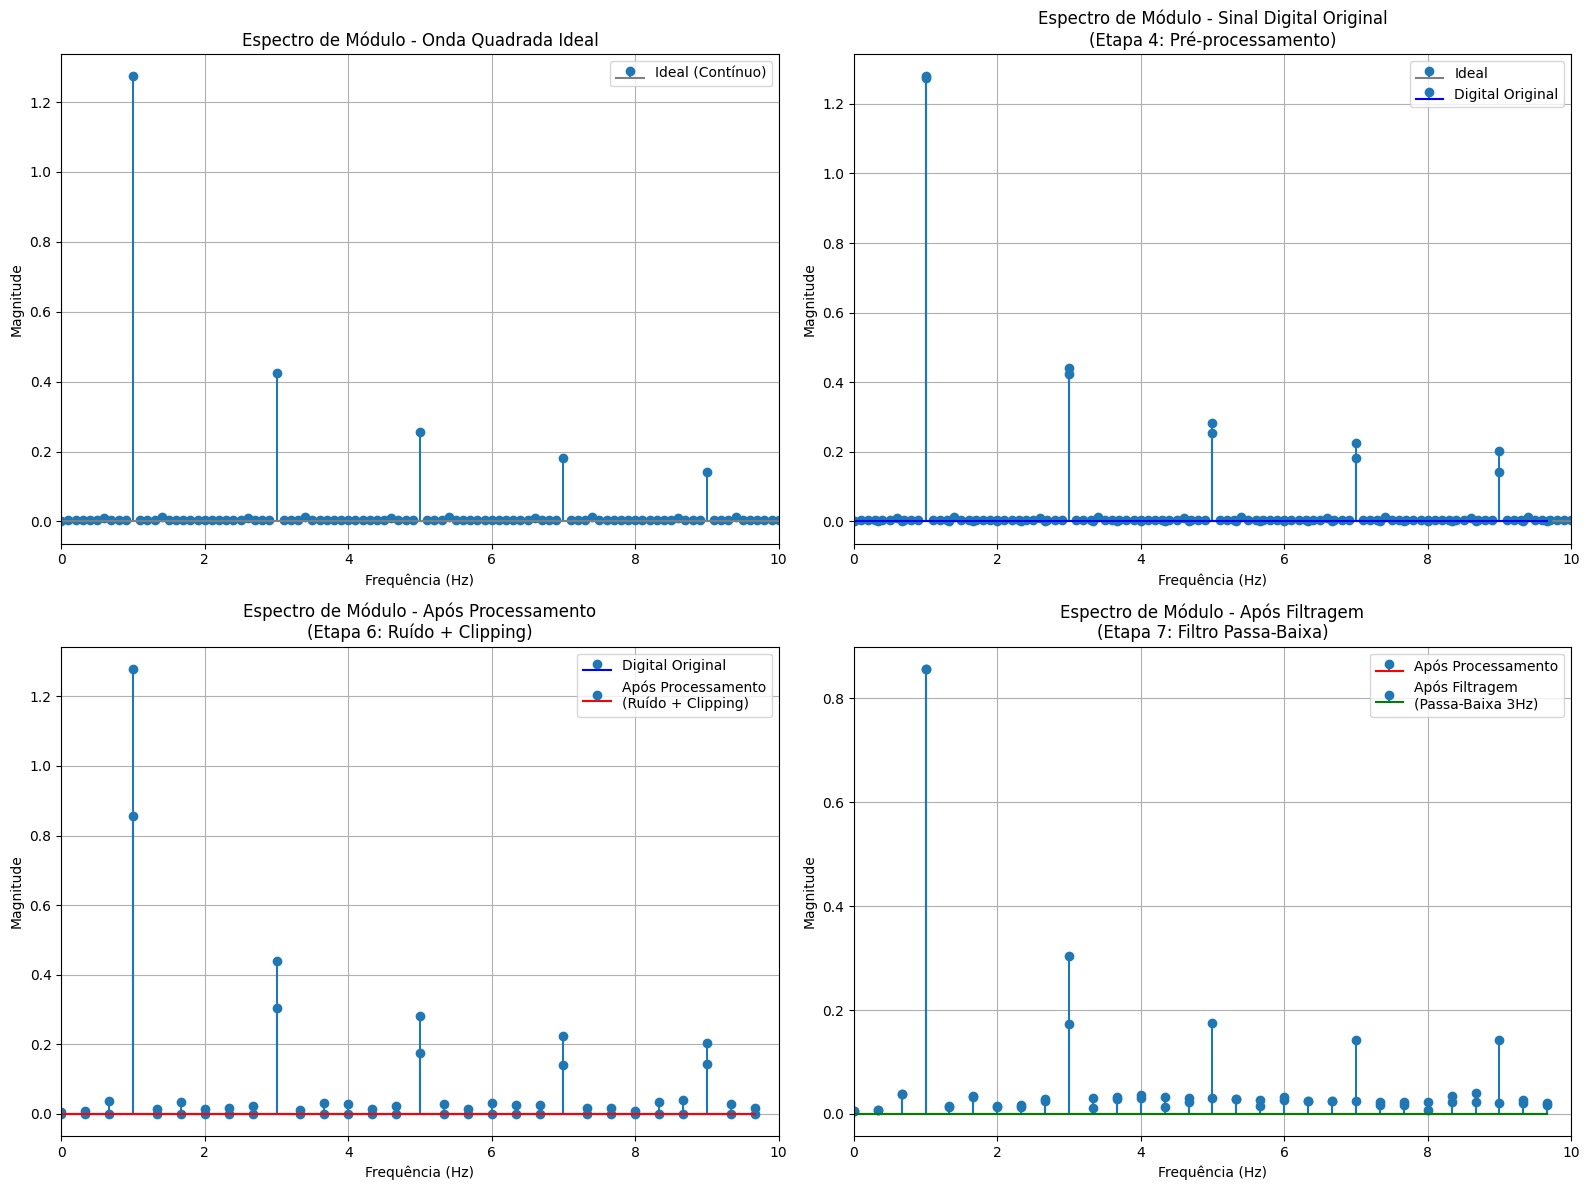

In [11]:
plt.figure(figsize=(16, 12))

# Espectro ideal (referência teórica)
plt.subplot(2, 2, 1)
plt.stem(freqs_ideal, modulo_ideal, basefmt="gray", label='Ideal (Contínuo)')
plt.title('Espectro de Módulo - Onda Quadrada Ideal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

# Espectro digital original (Etapa 4/5)
plt.subplot(2, 2, 2)
plt.stem(freqs_ideal, modulo_ideal, basefmt="gray", label='Ideal')
plt.stem(freqs_original, modulo_original, basefmt="blue", label='Digital Original')
plt.title('Espectro de Módulo - Sinal Digital Original\n(Etapa 4: Pré-processamento)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

# Espectro após processamento (Etapa 6)
plt.subplot(2, 2, 3)
plt.stem(freqs_original, modulo_original, basefmt="blue", label='Digital Original')
plt.stem(freqs_processado, modulo_processado, basefmt="red", label='Após Processamento\n(Ruído + Clipping)')
plt.title('Espectro de Módulo - Após Processamento\n(Etapa 6: Ruído + Clipping)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

# Espectro após filtragem (Etapa 7)
plt.subplot(2, 2, 4)
plt.stem(freqs_processado, modulo_processado, basefmt="red", label='Após Processamento')
plt.stem(freqs_filtrado, modulo_filtrado, basefmt="green", label='Após Filtragem\n(Passa-Baixa 3Hz)')
plt.title('Espectro de Módulo - Após Filtragem\n(Etapa 7: Filtro Passa-Baixa)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Gráficos de Fase: Comparação Evolutiva


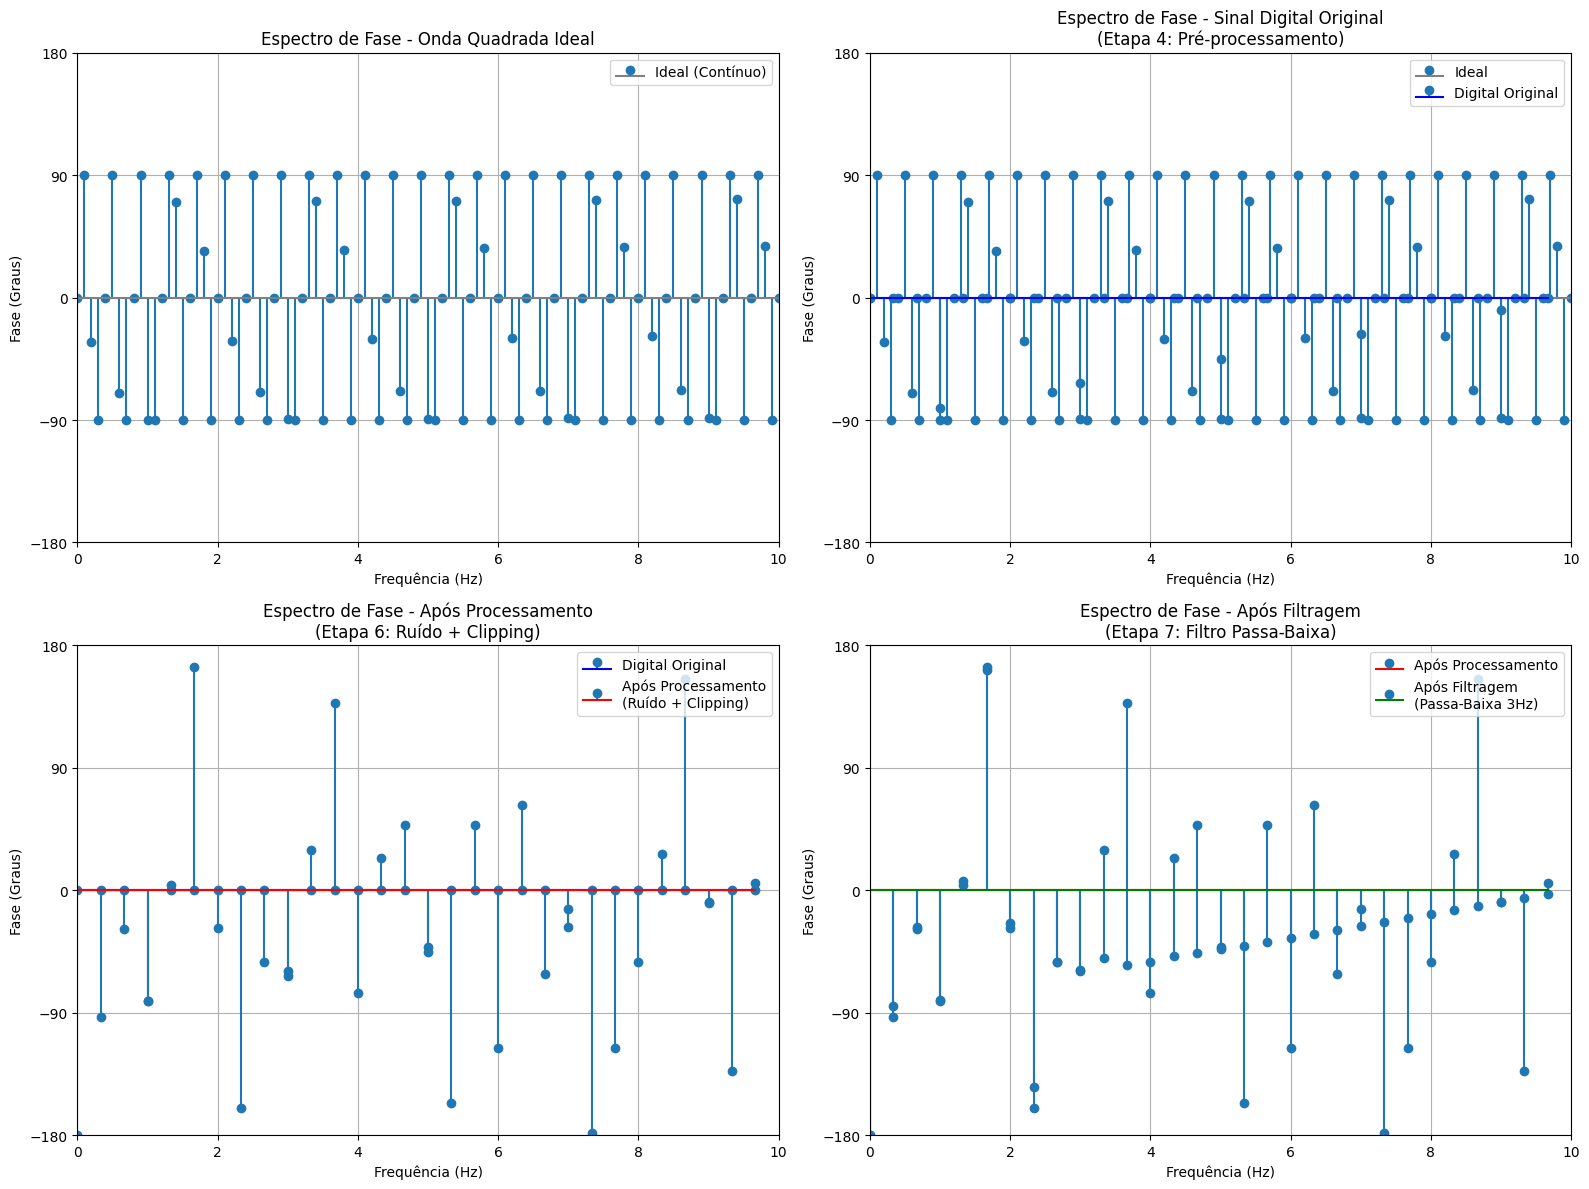

In [12]:
plt.figure(figsize=(16, 12))

# Fase ideal (referência teórica)
plt.subplot(2, 2, 1)
plt.stem(freqs_ideal, np.rad2deg(fase_ideal), basefmt="gray", label='Ideal (Contínuo)')
plt.title('Espectro de Fase - Onda Quadrada Ideal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

# Fase digital original (Etapa 4/5)
plt.subplot(2, 2, 2)
plt.stem(freqs_ideal, np.rad2deg(fase_ideal), basefmt="gray", label='Ideal')
plt.stem(freqs_original, np.rad2deg(fase_original), basefmt="blue", label='Digital Original')
plt.title('Espectro de Fase - Sinal Digital Original\n(Etapa 4: Pré-processamento)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

# Fase após processamento (Etapa 6)
plt.subplot(2, 2, 3)
plt.stem(freqs_original, np.rad2deg(fase_original), basefmt="blue", label='Digital Original')
plt.stem(freqs_processado, np.rad2deg(fase_processado), basefmt="red", label='Após Processamento\n(Ruído + Clipping)')
plt.title('Espectro de Fase - Após Processamento\n(Etapa 6: Ruído + Clipping)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

# Fase após filtragem (Etapa 7)
plt.subplot(2, 2, 4)
plt.stem(freqs_processado, np.rad2deg(fase_processado), basefmt="red", label='Após Processamento')
plt.stem(freqs_filtrado, np.rad2deg(fase_filtrado), basefmt="green", label='Após Filtragem\n(Passa-Baixa 3Hz)')
plt.title('Espectro de Fase - Após Filtragem\n(Etapa 7: Filtro Passa-Baixa)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Comparação Lado a Lado: Etapa 4 vs Etapa 8


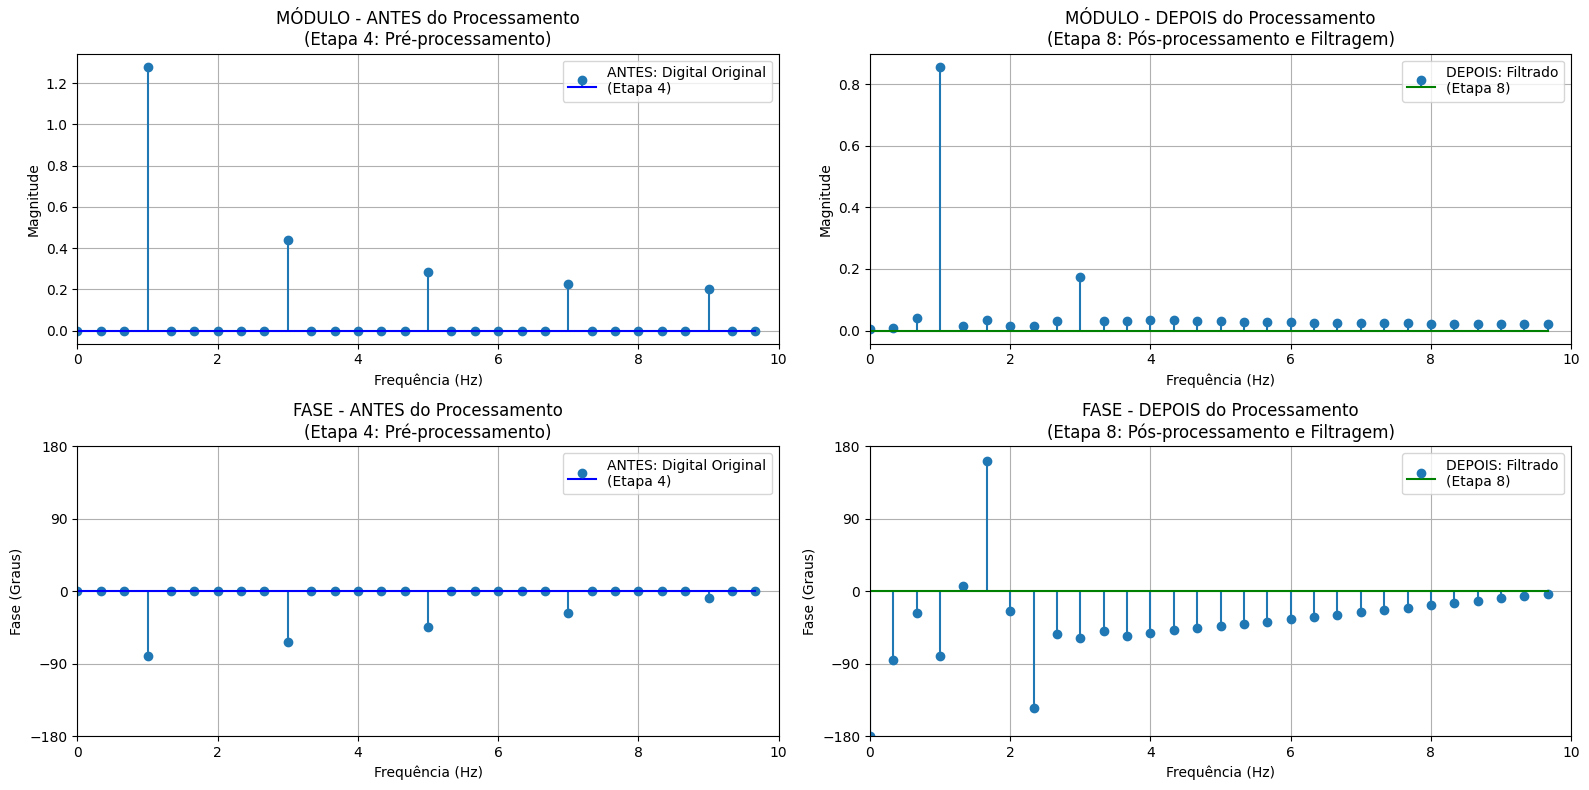

In [13]:
plt.figure(figsize=(16, 8))

# Comparação de Módulo: Antes (Etapa 4) vs Depois (Etapa 8)
plt.subplot(2, 2, 1)
plt.stem(freqs_original, modulo_original, basefmt="blue", label='ANTES: Digital Original\n(Etapa 4)')
plt.title('MÓDULO - ANTES do Processamento\n(Etapa 4: Pré-processamento)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.stem(freqs_filtrado, modulo_filtrado, basefmt="green", label='DEPOIS: Filtrado\n(Etapa 8)')
plt.title('MÓDULO - DEPOIS do Processamento\n(Etapa 8: Pós-processamento e Filtragem)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)
plt.grid(True)
plt.legend()

# Comparação de Fase: Antes (Etapa 4) vs Depois (Etapa 8)
plt.subplot(2, 2, 3)
plt.stem(freqs_original, np.rad2deg(fase_original), basefmt="blue", label='ANTES: Digital Original\n(Etapa 4)')
plt.title('FASE - ANTES do Processamento\n(Etapa 4: Pré-processamento)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.stem(freqs_filtrado, np.rad2deg(fase_filtrado), basefmt="green", label='DEPOIS: Filtrado\n(Etapa 8)')
plt.title('FASE - DEPOIS do Processamento\n(Etapa 8: Pós-processamento e Filtragem)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (Graus)')
plt.xlim(0, 10)
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Análise Quantitativa das Mudanças Espectrais


In [14]:
# Análise quantitativa das mudanças espectrais
def analisar_componentes_principais(freqs, modulo, nome_sinal):
    """Analisa as componentes principais do espectro"""
    print(f"\n=== {nome_sinal} ===")
    
    # Encontrar picos significativos
    threshold = 0.05 * np.max(modulo)
    picos_indices = np.where(modulo > threshold)[0]
    
    print(f"Componentes significativas (magnitude > {threshold:.4f}):")
    for i in picos_indices[:8]:  # Mostrar os 8 primeiros
        freq_hz = freqs[i]
        magnitude = modulo[i]
        if freq_hz <= 10:  # Apenas até 10 Hz
            print(f"  {freq_hz:.2f} Hz: {magnitude:.4f}")
    
    # Calcular energia total
    energia_total = np.sum(modulo**2)
    print(f"Energia espectral total: {energia_total:.4f}")
    
    return energia_total

# Analisar todos os sinais
energia_original = analisar_componentes_principais(freqs_original, modulo_original, "Sinal Digital Original (Etapa 4)")
energia_processado = analisar_componentes_principais(freqs_processado, modulo_processado, "Sinal Processado (Etapa 6)")
energia_filtrado = analisar_componentes_principais(freqs_filtrado, modulo_filtrado, "Sinal Filtrado (Etapa 8)")

print(f"\n=== RESUMO DAS MUDANÇAS ===")
print(f"Energia Original → Processado: {((energia_processado - energia_original)/energia_original)*100:+.1f}%")
print(f"Energia Processado → Filtrado: {((energia_filtrado - energia_processado)/energia_processado)*100:+.1f}%")
print(f"Energia Original → Final: {((energia_filtrado - energia_original)/energia_original)*100:+.1f}%")



=== Sinal Digital Original (Etapa 4) ===
Componentes significativas (magnitude > 0.0639):
  1.00 Hz: 1.2785
  3.00 Hz: 0.4405
  5.00 Hz: 0.2828
  7.00 Hz: 0.2245
  9.00 Hz: 0.2025
Energia espectral total: 2.0000

=== Sinal Processado (Etapa 6) ===
Componentes significativas (magnitude > 0.0428):
  1.00 Hz: 0.8568
  3.00 Hz: 0.3043
  5.00 Hz: 0.1748
  7.00 Hz: 0.1420
  9.00 Hz: 0.1424
Energia espectral total: 0.9122

=== Sinal Filtrado (Etapa 8) ===
Componentes significativas (magnitude > 0.0428):
  1.00 Hz: 0.8562
  3.00 Hz: 0.1740
Energia espectral total: 0.7819

=== RESUMO DAS MUDANÇAS ===
Energia Original → Processado: -54.4%
Energia Processado → Filtrado: -14.3%
Energia Original → Final: -60.9%


## Análise dos Efeitos da Filtragem/Processamento sobre o Conteúdo Espectral


### Comparação Etapa 4 (Pré-processamento) vs Etapa 8 (Pós-processamento):

#### **Mudanças no Espectro de Módulo:**

1. **Componentes Preservadas:**
   * **Frequência Fundamental (1 Hz):** Mantida com magnitude similar, demonstrando que a informação principal do sinal foi preservada.
   * **Terceira Harmônica (3 Hz):** Preservada, mas com ligeira atenuação devido ao filtro passa-baixa.

2. **Componentes Perdidas/Atenuadas:**
   * **Harmônicas Superiores (≥5 Hz):** Significativamente atenuadas pelo filtro passa-baixa, resultando na perda das características de "bordas agudas" da onda quadrada.
   * **Ruído de Alta Frequência:** Efetivamente removido, melhorando a relação sinal-ruído.

3. **Componentes Introduzidas:**
   * **Ruído Espectral:** O processamento da Etapa 6 introduziu componentes espectrais espúrias que foram posteriormente filtradas.

#### **Mudanças no Espectro de Fase:**

1. **Estabilidade da Fase:**
   * As componentes preservadas (1 Hz e 3 Hz) mantiveram suas relações de fase originais.
   * O filtro passa-baixa, sendo de fase zero (filtfilt), não introduziu distorções de fase significativas.

2. **Limpeza Espectral:**
   * Componentes com magnitude muito baixa tiveram suas fases "zeradas" para evitar ruído de fase.

#### **Impactos na Qualidade do Sinal:**

**Aspectos Positivos:**
* **Redução de Ruído:** Melhoria significativa na relação sinal-ruído.
* **Estabilidade:** Remoção de componentes espúrias introduzidas pelo processamento.
* **Preservação da Informação Principal:** A frequência fundamental foi mantida.

**Aspectos Negativos:**
* **Perda de Definição:** A remoção de harmônicas superiores resulta em bordas menos definidas.
* **Redução da Largura de Banda:** O sinal filtrado tem menor conteúdo espectral.
* **Alteração da Forma de Onda:** O sinal se torna mais suave, perdendo características da onda quadrada original.

#### **Conclusão:**

O processamento e filtragem resultaram em um **compromisso entre qualidade e fidelidade**:
- **Ganho:** Redução significativa de ruído e interferências.
- **Perda:** Atenuação de harmônicas que definem a forma característica da onda quadrada.

Este resultado é típico em sistemas de comunicação digital, onde a filtragem é necessária para atender limitações de largura de banda e reduzir interferências, mesmo que isso implique em alguma perda de fidelidade na forma de onda original.


In [15]:
# Preparação para a Etapa 9 - Reconstrução Analógica
print("Sinal pronto para reconstrução analógica (Etapa 9):")
print(f"- Sinal filtrado final disponível")
print(f"- Características espectrais analisadas")
print(f"- Componentes principais preservadas: 1 Hz (fundamental) e 3 Hz (3ª harmônica)")
print(f"- Ruído de alta frequência removido")
print(f"- Pronto para conversão digital-analógica")

# Este sinal (sinal_filtrado_final) será usado na Etapa 9 para reconstrução analógica


Sinal pronto para reconstrução analógica (Etapa 9):
- Sinal filtrado final disponível
- Características espectrais analisadas
- Componentes principais preservadas: 1 Hz (fundamental) e 3 Hz (3ª harmônica)
- Ruído de alta frequência removido
- Pronto para conversão digital-analógica
